In [ ]:
from speedymf import *
import math, pickle
import matplotlib.pyplot as plt 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Seeding for repeatability 
np.random.seed(42)

# Define number of fidelity-levels 
n_fidelities = 3 

# Define a list of sample sizes
sample_sizes = [15, 100, 250]

# Define the high and low-fidelity functions
funcs = [
    lambda x: np.exp(-x) * np.sin(2*math.pi*x), 
    lambda x: np.sin(2*math.pi*x),
    lambda x: np.exp(-x)
]

# Making some testing data 
Xtest = np.linspace(0.6, 1.4, 250).reshape(-1,1)

with open("data/FlameSpeedData.pkl", 'rb') as infile:
    data_dict = pickle.load(infile)

# Initializing noise vars
for level in data_dict.keys():
    data_dict[level]['Y'] *= 0.01 # Converting to m/s
    data_dict[level]['noise_var'] = 1e-6

In [6]:
model = StochasticHyperkriging(data_dict, rbf, 9, 0.0, 5.0, mu = -1.0, cov = 1e-4)

In [9]:
model.optimize(0, params_to_optimize = ['k_mu','k_L', 'Z', 'q_mu', 'q_L'], epochs = 100, batch_size = 250, lr = 1e-3, N_mc = 10, beta1 = 0.9, beta2 = 0.999, seed = 42, shuffle = False)

100%|██████████| 100/100 [00:03<00:00, 28.76it/s, Loss: 704025.35858, LR: 1.00e-03]


In [16]:
model.optimize(1, params_to_optimize = ['k_mu','k_L', 'Z', 'q_mu', 'q_L'], epochs = 1000, batch_size = 250, lr = 1e-3, N_mc = 15, beta1 = 0.9, beta2 = 0.999, seed = 42, shuffle = False)

100%|██████████| 1000/1000 [00:43<00:00, 22.73it/s, Loss: 67136.50758 Learning Rate: 1.00e-03]


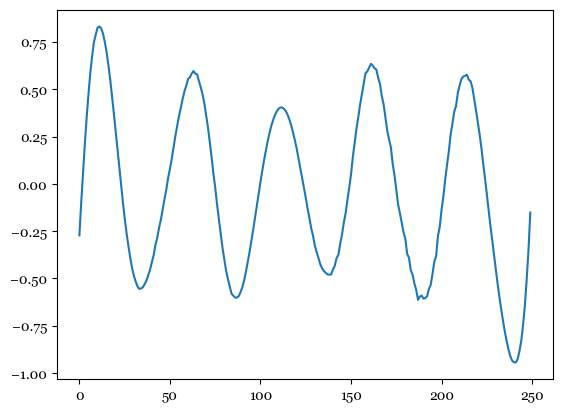

In [17]:
mean, cov = model.predict(Xtest, 1, N_mc = 25)
plt.plot(mean)

In [26]:
model.optimize(2, params_to_optimize = ['k_mu','k_L', 'Z', 'q_mu', 'q_L'], epochs = 1000, batch_size = 250, lr = 1e-3, N_mc = 15, beta1 = 0.9, beta2 = 0.999, seed = 42, shuffle = False)

100%|██████████| 1000/1000 [00:39<00:00, 25.18it/s, Loss: 1420.44838 Learning Rate: 1.00e-03]


In [27]:
mean, cov = model.predict(Xtest, 2, N_mc = 100) 
conf = 2 * np.sqrt(np.diag(cov)).ravel() 

In [20]:
kr_model = LogNormalGP(data_dict[2]['X'], data_dict[2]['Y'], noise_var = data_dict[2]['noise_var'], kernel = rbf, mu = np.zeros(2), cov = np.eye(2)*1e-6)

In [22]:
kr_model.optimize(
    lr = 1e-1, 
    epochs = 500,
    N_mc = 100
)

100%|██████████| 500/500 [00:08<00:00, 58.93it/s, Loss: -7.36405 Learning Rate: 1.00e-01]


In [23]:
kr_mean, kr_cov = kr_model.predict(Xtest, N_mc = 1000)
kr_conf = 2 * np.sqrt(np.diag(kr_cov)).ravel()

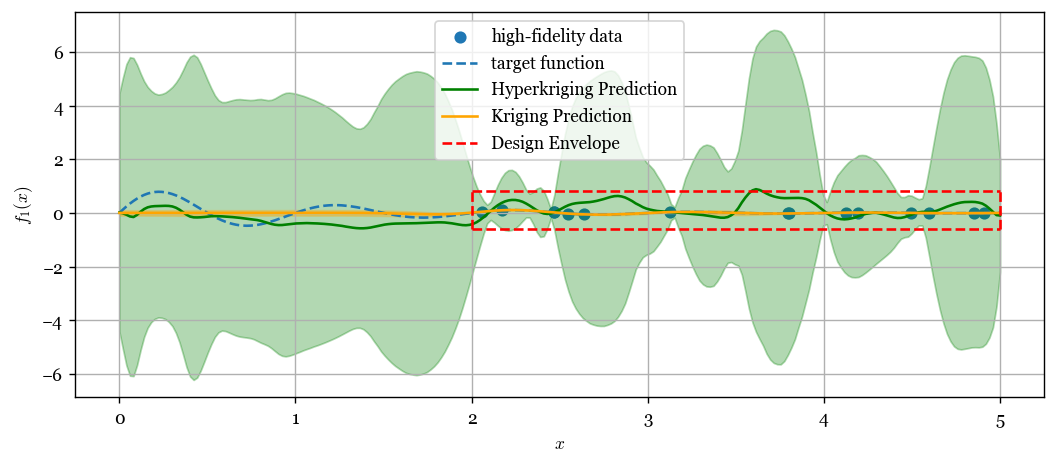

In [28]:
plt.figure(figsize=(10,4),dpi = 125)
plt.scatter(hf_data[:,0], hf_data[:,1], label = 'high-fidelity data')
plt.plot(Xtest.ravel(), funcs[0](Xtest), linestyle = 'dashed', label = 'target function')
plt.plot(Xtest.ravel(), mean.ravel(), color = 'green', label = 'Hyperkriging Prediction')
plt.fill_between(Xtest.ravel(), mean.ravel()-conf, mean.ravel()+conf, color = 'green', alpha = 0.3)

plt.plot(Xtest.ravel(), kr_mean.ravel(), color = 'orange', label = 'Kriging Prediction')
plt.fill_between(Xtest.ravel(), kr_mean.ravel() - kr_conf, kr_mean.ravel()+kr_conf, alpha = 0.3, color = 'orange')

plt.plot([cutoff, cutoff], [-0.6, 0.8], linestyle = 'dashed', color = 'red', label = 'Design Envelope')
plt.plot([cutoff, 5.0], [0.8, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([5.0, 5.0], [-0.6, 0.8], linestyle = 'dashed', color = 'red')
plt.plot([cutoff, 5.0], [-0.6, -0.6], linestyle = 'dashed', color = 'red')
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$f_1(x)$")
plt.legend()